In [294]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms , models
from torch.autograd import Variable
import PIL
from PIL import Image
import copy
import matplotlib.pyplot as plt
%matplotlib inline

In [295]:
# Defining the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
print(device)

cuda


In [296]:
#defining the output image size
imsize = 200

#defining the transforms
transform = transforms.Compose([transforms.Resize(imsize) ,
                              transforms.ToTensor()])

#Defining the function to load the images
# Function to load and preprocess an image
def image_loader(image_path, imsize=200):
    image = Image.open(image_path).convert('RGB')  # Convert to RGB if not already
    loader = transforms.Compose([
        transforms.Resize((imsize, imsize)),  # Resize to 200x200
        transforms.ToTensor()  # Convert to PyTorch tensor
    ])
    image = loader(image).unsqueeze(0)  # Add a batch dimension
    return image
# def image_loader(img_path):
#     image = Image.open(img_path)
#     image = Variable(transform(image))
#     image = image.unsqueeze(0)
#     return image




In [297]:
from google.colab import  drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [298]:
#Checking whether the files are properly mounted or not
import os
print("Style Image : {}".format(os.path.isfile("/content/drive/My Drive/Neural Style/paint1.png")))
print("Content Image : {}".format(os.path.isfile("/content/drive/My Drive/Neural Style/building.jpeg")))


Style Image : True
Content Image : True


In [299]:
#Defining getting the tensors for style and content image
style_image = image_loader("/content/drive/My Drive/Neural Style/paint1.png").type(dtype)
content_image = image_loader("/content/drive/My Drive/Neural Style/building.jpeg").type(dtype)

assert style_image.size() == content_image.size() ,\
    "Import the images of same size"
print(style_image.size())
print(content_image.size())

torch.Size([1, 3, 200, 200])
torch.Size([1, 3, 200, 200])


In [300]:
from PIL import Image
import torchvision.transforms as transforms
import torch

# Function to load and preprocess an image
def image_loader(image_path, imsize=200):
    image = Image.open(image_path).convert('RGB')  # Convert to RGB if not already
    loader = transforms.Compose([
        transforms.Resize((imsize, imsize)),  # Resize to 200x200
        transforms.ToTensor()  # Convert to PyTorch tensor
    ])
    image = loader(image).unsqueeze(0)  # Add a batch dimension
    return image

# Define the data type (dtype) based on whether a GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load and preprocess the style image
style_image_path = "/content/drive/My Drive/Neural Style/paint1.png"
style_image = image_loader(style_image_path).to(device)

# Load and preprocess the content image
content_image_path = "/content/drive/My Drive/Neural Style/building.jpeg"
content_image = image_loader(content_image_path).to(device)

# Check the size of the processed images
assert style_image.size() == content_image.size(), "Imported images must be of the same size"
print("Style image size:", style_image.size())
print("Content image size:", content_image.size())


Style image size: torch.Size([1, 3, 200, 200])
Content image size: torch.Size([1, 3, 200, 200])


In [301]:
style_image.shape

torch.Size([1, 3, 200, 200])

In [302]:
content_image.shape

torch.Size([1, 3, 200, 200])

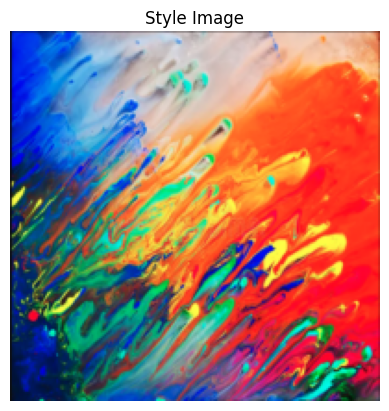

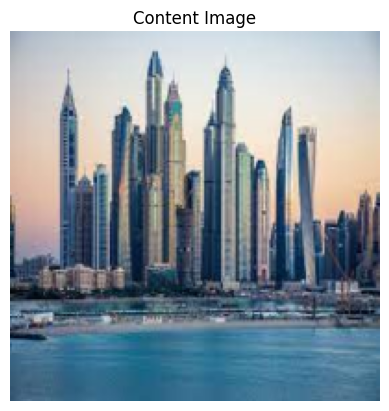

In [303]:
#Creating a function to diplay ourloaded images

unload =transforms.ToPILImage()

plt.ion()

def imshow(tensor , title = None , result = None):
    image = tensor.cpu().clone() #using clone not affecting the original tensor
    image = image.view(3 , imsize , imsize )
    image = unload(image)
    plt.axis('off')
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    if title == "Stylized Image" and result is not None:
        plt.savefig("/content/drive/My Drive/Neural Style/results{}.jpg".format(result))

#Style Image
plt.figure()
imshow(style_image , title = "Style Image")

#Content Image
plt.figure()
imshow(content_image , title = "Content Image")
#print(content_image.size())

# Content Loss

The content Loss is given by the below equation
![alt text](https://cdn-images-1.medium.com/max/1000/1*2qVOACtvA3m26Q2bP4aN0A.png)

Content loss  is the squared-error loss between the feature representation of the original image and the feature representation of the generated image.



In [304]:
#Defining the class for content loss

class ContentLoss(nn.Module):

    def __init__(self, target,weight):
        super(ContentLoss, self).__init__()

        self.target = target.detach()*weight
        self.weight = weight
        self.criterion = nn.MSELoss()

    def forward(self, input):
        self.loss = self.criterion.forward(input * self.weight , self.target)
        self.output = input
        return self.output

    def backward(self , retain_graph = True):
        self.loss.backward(retain_graph = retain_graph)
        return self.loss

# Style Loss

## Gram Matrices

Consider two vectors(more specifically 2 flattened feature vectors from a convolutional feature map of depth C) representing features of the input space, and their dot product give us the information about the relation between them. The lesser the product the more different the learned features are and greater the product, the more correlated the features are. In other words,** the lesser the product, the lesser the two features co-occur and the greater it is, the more they occur together**. This in a sense gives information about an image’s style(texture) and zero information about its spatial structure, since we already flatten the feature and perform dot product on top of it.

Now take all C feature vectors(flattened) from a convolutional feature map of depth C and compute the dot product with every one of them(including with a feature vector itself). **The result is the Gram Matrix(of size CxC**).

The gram matrix is given by the formula in image below

![link text](https://cdn-images-1.medium.com/max/1000/1*C3fkQanKHMwOi_rf0q0OQQ.png)

## Style Loss Function

The style loss is the mean-squared distance between the style representation (gram matrix) of the style image and the style representation of the output image in one layer l.

![alt text](https://cdn-images-1.medium.com/max/1000/1*66C6jaZcdEuxUoBvXVuPhQ.png)

We apply the loss function on different layers to get the total loss.

![alt text](https://cdn-images-1.medium.com/max/1000/1*6ZqgAS5gDn25jncXDRfqog.png)

In [305]:
#Defining the function to define the gram matrix

class gram_matrix(nn.Module):
    def forward(self , input):
        a, b, c, d = input.size()  # a=batch size(=1)
        # b=number of feature maps
        # (c,d)=dimensions of a f. map (N=c*d)

        features = input.view(a * b, c * d)

        G = torch.mm(features, features.t())  # compute the gram product

        # we 'normalize' the values of the gram matrix
        # by dividing by the number of element in each feature maps.
        return G.div(a * b * c * d)

In [306]:
#Defining the class for style loss

class StyleLoss(nn.Module):

    def __init__(self, target ,weight):
        super(StyleLoss, self).__init__()
        self.target = target.detach()*weight
        self.weight = weight
        self.Gram = gram_matrix()
        self.criterion = nn.MSELoss()

    def forward(self, input):
        self.output = input.clone()
        self.G = self.Gram.forward(input)
        self.G.mul_(self.weight)
        self.loss = self.criterion(self.G ,self.target)
        return self.output

    def backward(self , retain_graph = True):
        self.loss.backward(retain_graph = retain_graph)
        return self.loss

In [307]:
# Importing the pretrained model (The paper uses VGG19 model)

cnn = models.vgg19(pretrained  = True).features.to(device)
print(cnn)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [308]:

# desired depth layers to compute style/content losses :
content_layers = ['conv_4']
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

# just in order to have an iterable access to or list of content/syle losses
content_losses = []
style_losses = []

model = nn.Sequential()  # the new Sequential module network
gram = gram_matrix()  # we need a gram module in order to compute style targets

# move these modules to the GPU if possible:
if torch.cuda.is_available():
    model = model.cuda()
    gram = gram.cuda()

# weigth associated with content and style losses
content_weight = 10
style_weight = 1000

i = 1
for layer in list(cnn):
    if isinstance(layer, nn.Conv2d):
        name = "conv_" + str(i)
        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model.forward(content_image).clone()
            content_loss = ContentLoss(target, content_weight)
            model.add_module("content_loss_" + str(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model.forward(style_image).clone()
            target_feature_gram = gram.forward(target_feature)
            style_loss = StyleLoss(target_feature_gram, style_weight)
            model.add_module("style_loss_" + str(i), style_loss)
            style_losses.append(style_loss)

    if isinstance(layer, nn.ReLU):
        name = "relu_" + str(i)
        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model.forward(content_image).clone()
            content_loss = ContentLoss(target, content_weight)
            model.add_module("content_loss_" + str(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model.forward(style_image).clone()
            target_feature_gram = gram.forward(target_feature)
            style_loss = StyleLoss(target_feature_gram, style_weight)
            model.add_module("style_loss_" + str(i), style_loss)
            style_losses.append(style_loss)

        i += 1

    if isinstance(layer, nn.MaxPool2d):
        name = "pool_" + str(i)
        model.add_module(name, layer)

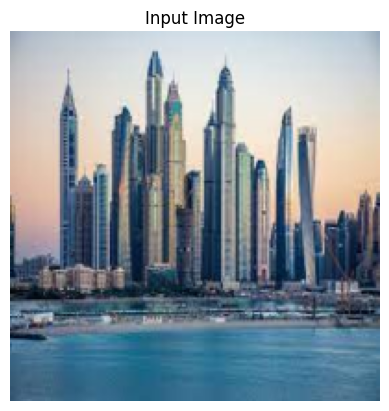

In [309]:
inp_img = content_image.clone()
plt.figure()
imshow(inp_img , title = "Input Image")

In [310]:
#Defining the input to the optimizer , the author of the paper suggests to use BFGS optimizer

inp = nn.Parameter(inp_img.data)
optimizer = optim.LBFGS([inp])

Building the style transfer model
Run : [50]
Style_loss : 87.779007 || Content_loss : 356.562500

Run : [100]
Style_loss : 70.078270 || Content_loss : 324.074188

Run : [150]
Style_loss : 72.022575 || Content_loss : 318.847443

Run : [200]
Style_loss : 68.160812 || Content_loss : 314.576630

Run : [250]
Style_loss : 72.634377 || Content_loss : 348.107635

Run : [300]
Style_loss : 119.360062 || Content_loss : 372.452240

Run : [350]
Style_loss : 106.564293 || Content_loss : 471.111481

Run : [400]
Style_loss : 594.343445 || Content_loss : 659.234070

Run : [450]
Style_loss : 109.635193 || Content_loss : 452.799683

Run : [500]
Style_loss : 157.093628 || Content_loss : 579.094788



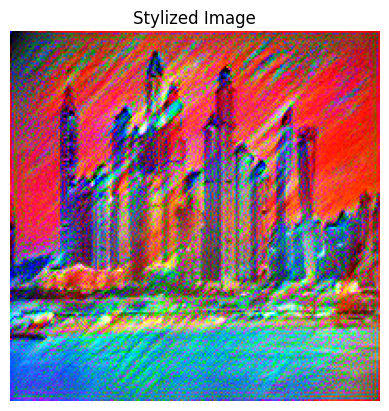

In [311]:
# The style Transfer Process
num_runs = 500
print("Building the style transfer model")

run = [0]
while run[0] <= num_runs:

    def closure():
        inp.data.clamp_(0,1)
        optimizer.zero_grad()
        model.forward(inp)
        style_score = 0
        content_score = 0

        for sl in style_losses:
            style_score += sl.backward()
        for cl in content_losses:
            content_score += cl.backward()



        run[0] += 1
        if run[0] % 50 == 0:
            print("Run : {}".format(run))
            print("Style_loss : {:4f} || Content_loss : {:4f}".format(style_score.item() , content_score.item()))
            print()
        return style_score + content_score
    optimizer.step(closure)

# last correction
inp.data.clamp_(0,1)
#Displaying the results
plt.figure()
imshow(inp.data , title  = "Stylized Image" , result = 'new')
#plt.plt.savefig("Results_macchu.jpg")
plt.ioff()

